<div style="text-align: center; font-size: 40px; font-family: 'Ubuntu', sans-serif;">
    <strong>Deep Faker: MNIST</strong>
</div>


In [1]:
import matplotlib.font_manager as fm
font_paths = [f.name for f in fm.fontManager.ttflist]
print(font_paths)

['DejaVu Serif Display', 'DejaVu Sans Mono', 'cmmi10', 'DejaVu Sans Mono', 'DejaVu Serif', 'DejaVu Sans', 'DejaVu Sans Mono', 'cmsy10', 'STIXSizeThreeSym', 'DejaVu Serif', 'DejaVu Serif', 'STIXGeneral', 'DejaVu Sans Mono', 'DejaVu Sans', 'cmtt10', 'STIXNonUnicode', 'STIXGeneral', 'DejaVu Serif', 'DejaVu Sans', 'STIXSizeTwoSym', 'cmb10', 'cmss10', 'STIXNonUnicode', 'STIXSizeFiveSym', 'cmr10', 'cmex10', 'STIXSizeTwoSym', 'STIXSizeFourSym', 'STIXNonUnicode', 'STIXGeneral', 'DejaVu Sans Display', 'STIXNonUnicode', 'STIXGeneral', 'STIXSizeOneSym', 'STIXSizeThreeSym', 'DejaVu Sans', 'STIXSizeFourSym', 'STIXSizeOneSym', 'Lato', 'DejaVu Sans Mono', 'URW Gothic', 'Liberation Sans', 'Ubuntu', 'URW Bookman', 'Liberation Mono', 'Source Code Pro', 'Nimbus Sans', 'Source Code Pro', 'Nimbus Sans', 'DejaVu Serif', 'Noto Sans Mono', 'Lato', 'Nimbus Sans Narrow', 'P052', 'URW Gothic', 'Source Code Pro', 'DejaVu Sans', 'Lato', 'Lato', 'Source Code Pro', 'Lato', 'Ubuntu', 'Source Code Pro', 'Ubuntu Conden

# 1. Preprocess

## 1.1 Module Loading

In [12]:
# Standard library
import os
import struct
import time  

# Third-party library
import numpy as np
from math import e
import matplotlib.pyplot as plt
from tqdm import tqdm  
from tqdm.notebook import tqdm as notebook_tqdm  

# PyTorch 
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import MSELoss
import torch.utils.data
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor, transforms

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [13]:
def check_gpu_memory():
    if torch.cuda.is_available():
        print(f"Number of GPUs: {torch.cuda.device_count()}")
        for i in range(torch.cuda.device_count()):
            print(f"\nGPU {i}: {torch.cuda.get_device_name(i)}")
            total_memory = torch.cuda.get_device_properties(i).total_memory / (1024**3)  # Convert bytes to GB
            reserved_memory = torch.cuda.memory_reserved(i) / (1024**3)
            allocated_memory = torch.cuda.memory_allocated(i) / (1024**3)
            free_memory = reserved_memory - allocated_memory
            print(f"  Total memory: {total_memory:.2f} GB")
            print(f"  Reserved memory: {reserved_memory:.2f} GB")
            print(f"  Allocated memory: {allocated_memory:.2f} GB")
            print(f"  Free memory: {free_memory:.2f} GB")
    else:
        print("No GPU is available.")

check_gpu_memory()

Number of GPUs: 2

GPU 0: Tesla V100-PCIE-32GB
  Total memory: 31.74 GB
  Reserved memory: 0.00 GB
  Allocated memory: 0.00 GB
  Free memory: 0.00 GB

GPU 1: Tesla V100-PCIE-32GB
  Total memory: 31.74 GB
  Reserved memory: 0.00 GB
  Allocated memory: 0.00 GB
  Free memory: 0.00 GB


In [14]:
class MNISTDataset(Dataset):
    def __init__(self, image_path, label_path, transform=None):
        """
        Custom Dataset to load MNIST raw data.

        Args:
            image_path (str): Path to the images file.
            label_path (str): Path to the labels file.
            transform (callable, optional): Transform to apply to images.
        """
        self.images = self._read_images(image_path)
        self.labels = self._read_labels(label_path)
        self.transform = transform
        
    def _read_images(self, filepath):
        with open(filepath, 'rb') as f:
            magic, num, rows, cols = struct.unpack('>IIII', f.read(16))
            images = np.fromfile(f, dtype=np.uint8).reshape(num, rows, cols)
        return images

    def _read_labels(self, filepath):
        with open(filepath, 'rb') as f:
            magic, num = struct.unpack('>II', f.read(8))
            labels = np.fromfile(f, dtype=np.uint8)
        return labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

# Paths to the raw MNIST files
dataset_path = "/home/gridsan/groups/datasets/MNIST/raw"
train_images_path = os.path.join(dataset_path, "train-images-idx3-ubyte")
train_labels_path = os.path.join(dataset_path, "train-labels-idx1-ubyte")
test_images_path = os.path.join(dataset_path, "t10k-images-idx3-ubyte")
test_labels_path = os.path.join(dataset_path, "t10k-labels-idx1-ubyte")

from torchvision import transforms

transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Normalize((0.5,), (0.5,))  
])

train_dataset = MNISTDataset(train_images_path, train_labels_path, transform=transform)
test_dataset = MNISTDataset(test_images_path, test_labels_path, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=256, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=256, shuffle=False)

for images, labels in train_loader:
    print(f"Batch images shape: {images.shape}")
    print(f"Batch labels shape: {labels.shape}")
    break


Batch images shape: torch.Size([256, 1, 28, 28])
Batch labels shape: torch.Size([256])


## 1.2 MNIST Visualization

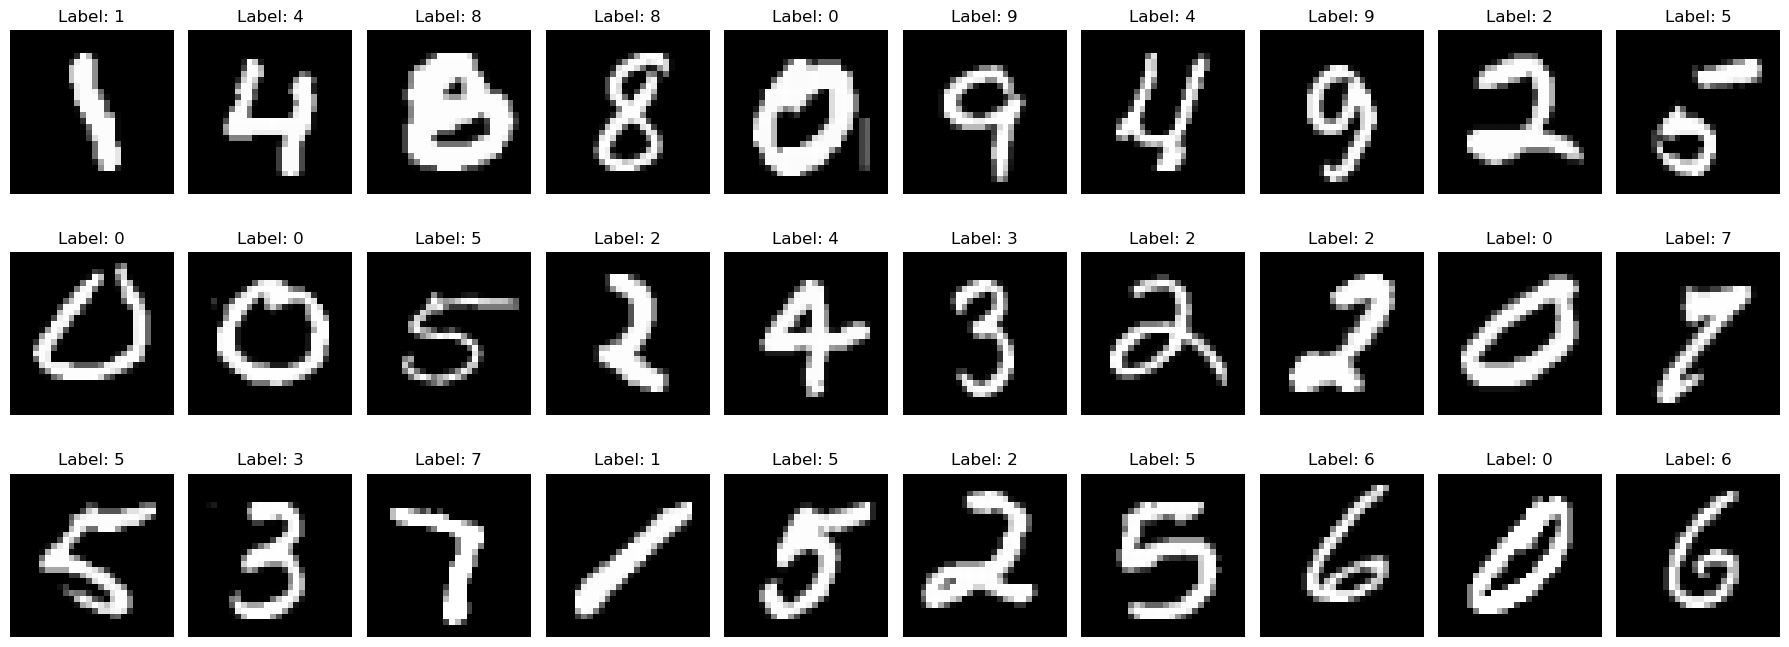

In [5]:
data_iter = iter(train_loader)
images, labels = next(data_iter)

# Plot 20 images and labels
fig, axes = plt.subplots(3, 10, figsize=(18, 7))
for i, ax in enumerate(axes.flatten()):
    ax.imshow(images[i].squeeze(), cmap="gray")
    ax.set_title(f"Label: {labels[i].item()}")
    ax.axis("off")

plt.tight_layout()
plt.show()

# 2. Model Architecture

## 2.1 Autoencoder

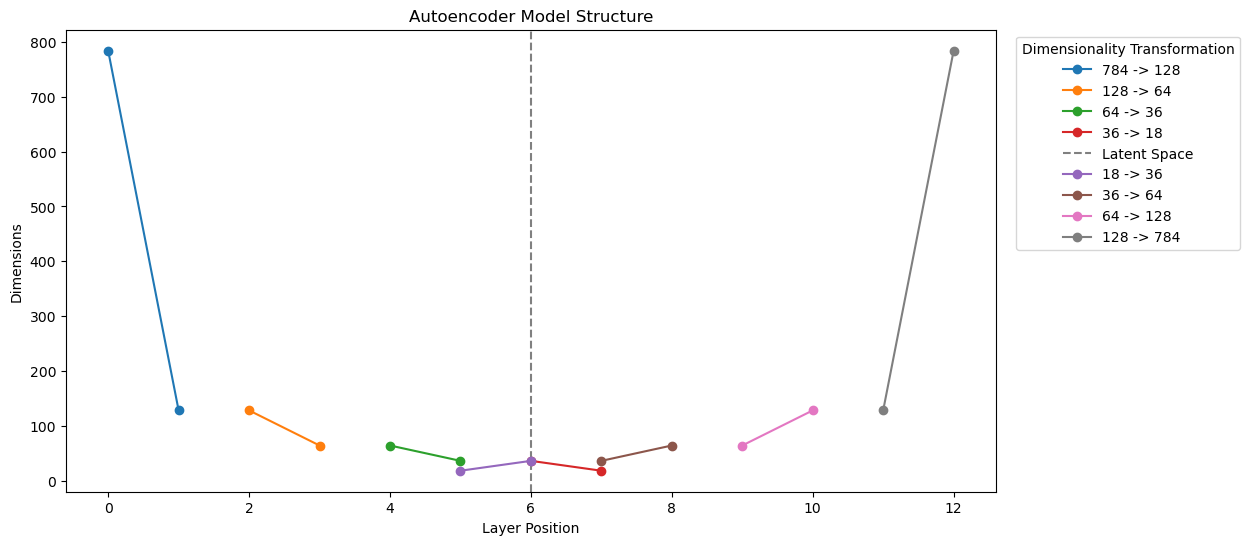

In [7]:
class AE(torch.nn.Module):
    def __init__(self, input_dim, hidden_dims):
        super().__init__()
        assert hidden_dims[-1] == 2, "2 as the latent dimension for generating a 2D image grid during evaluation"
        
        # Define the encoder network
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(input_dim, hidden_dims[0]),
            torch.nn.Sigmoid(),
            torch.nn.Linear(hidden_dims[0], hidden_dims[1]),
            torch.nn.Sigmoid(),
            torch.nn.Linear(hidden_dims[1], hidden_dims[2]),
            torch.nn.Sigmoid(),
            torch.nn.Linear(hidden_dims[2], hidden_dims[3]),
        )

        # Define the decoder network
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(hidden_dims[3], hidden_dims[2]),
            torch.nn.Sigmoid(),
            torch.nn.Linear(hidden_dims[2], hidden_dims[1]),
            torch.nn.Sigmoid(),
            torch.nn.Linear(hidden_dims[1], hidden_dims[0]),
            torch.nn.Sigmoid(),
            torch.nn.Linear(hidden_dims[0], input_dim)
        )

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decode(encoded)
        return {"imgs": decoded}
    
    def plot_model_structure(self):
        
        import matplotlib.pyplot as plt

        def plot_layers(layers, title, start_pos):
            layer_pos = start_pos
            for layer in layers:
                if isinstance(layer, torch.nn.Linear):
                    plt.plot([layer_pos, layer_pos + 1], [layer.in_features, layer.out_features], 'o-', label=f"{layer.in_features} -> {layer.out_features}")
                layer_pos += 1

        plt.figure(figsize=(12, 6))
        
        # Plot encoder
        plot_layers(self.encoder, "Encoder", 0)
        
        # Add a separator for the latent space
        plt.axvline(x=6, color='gray', linestyle='--', label="Latent Space")
        
        # Plot decoder
        plot_layers(self.decoder, "Decoder", 5)
        
        plt.title("Autoencoder Model Structure")
        plt.xlabel("Layer Position")
        plt.ylabel("Dimensions")
        plt.legend(loc='upper right',bbox_to_anchor=(1.27, 1),title="Dimensionality Transformation")
        plt.show()

input_dim = 784  # Specifically for MNIST
hidden_dims =  [128, 64, 36, 18, 2]
model = AE(input_dim, hidden_dims)
model.plot_model_structure()


## 2.2 Untrained model

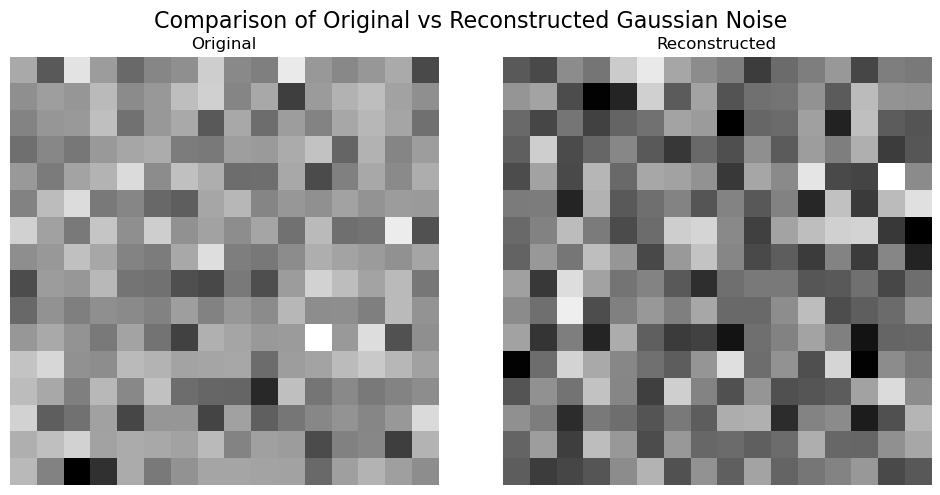

In [9]:
def plot_test_output_side_by_side(test_tensor, test_out, num_images=1):
    """
    Plots the original input tensor and its reconstructed output side by side.

    Args:
        test_tensor (torch.Tensor): Original input tensor.
        test_out (torch.Tensor): Reconstructed output from the autoencoder.
        num_images (int): Number of examples to visualize (defaults to 1).
    """
    # Convert tensors to numpy for visualization
    original = test_tensor[:num_images].cpu().numpy()
    reconstructed = test_out['imgs'][:num_images].cpu().numpy()

    # Plot the original vs reconstructed data
    plt.figure(figsize=(10, 5))
    for i in range(num_images):
        # Original
        plt.subplot(num_images, 2, 2 * i + 1)
        plt.imshow(original[i].reshape(16, 16), cmap="gray") 
        plt.axis("off")
        plt.title("Original")

        # Reconstructed
        plt.subplot(num_images, 2, 2 * i + 2)
        plt.imshow(reconstructed[i].reshape(16, 16), cmap="gray")
        plt.axis("off")
        plt.title("Reconstructed")

    plt.suptitle("Comparison of Original vs Reconstructed Gaussian Noise", fontsize=16)
    plt.tight_layout()
    plt.show()

### Test
hidden_dims = [128, 64, 36, 2]
input_dim = 256
test_tensor = torch.randn([1, input_dim]).to(device)
ae_test = AE(input_dim, hidden_dims).to(device)

with torch.no_grad():
  test_out = ae_test(test_tensor)

plot_test_output_side_by_side(test_tensor, test_out, num_images=1)

# 3. Training


## 3.1 Loss Function

In [10]:
mse = torch.nn.MSELoss()

def loss_func(model, x, reg_func=None, coeff=1e-3):
    output = model.module(x)
    err = mse(output['imgs'], x)
    logpx_z = -1.0 * torch.sum(err)

    if reg_func is not None:
      reg = reg_func(output)
    else:
      reg = 0.0

    return -1.0 * torch.mean(logpx_z + coeff * reg)

def loss_AE(model, x):
    reconstructed = model(x)['imgs']
    return mse(reconstructed, x)

## 3.2 Train

In [11]:
def train_model(model, train_loader, num_epochs, device, checkpoint_interval=50):
    """
    Trains a model and saves checkpoints at specified intervals, recording loss.

    Args:
        model (torch.nn.Module): The model to train.
        train_loader (DataLoader): DataLoader for the training dataset.
        num_epochs (int): Number of epochs to train.
        device (torch.device): Device for training (e.g., 'cpu' or 'cuda').
        checkpoint_interval (int): Save a checkpoint every `checkpoint_interval` epochs.
    
    Returns:
        list: List of average loss per epoch.
    """
    # Define the optimizer and loss function
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-8)
    mse = MSELoss()
 
    epoch_losses = []

    # Start training loop
    total_start_time = time.time() 
    for epoch in range(1, num_epochs + 1):
        epoch_start_time = time.time()
        model.train() 
        running_loss = 0.0

        # TQDM
        train_progress = tqdm(train_loader, desc=f"Epoch [{epoch}/{num_epochs}]")
        for images, _ in train_progress:
            # Flatten images to match input dimensions
            images = images.view(images.size(0), -1).to(device) 

            # Forward
            reconstructed = model(images)['imgs']
            loss = mse(reconstructed, images)

            # Backward
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Loss
            running_loss += loss.item()

            # Update tqdm
            train_progress.set_postfix({"Loss": f"{running_loss / len(train_loader):.4f}"})
        
        epoch_loss = running_loss / len(train_loader)
        epoch_losses.append(epoch_loss)        
        epoch_end_time = time.time()
        epoch_duration = epoch_end_time - epoch_start_time
        print(f"Epoch [{epoch}/{num_epochs}], Loss: {epoch_loss:.4f}, Time: {epoch_duration:.2f} seconds")

        # Save checkpoint
        if epoch % checkpoint_interval == 0:
            checkpoint_path = f"./checkpoints/checkpoint_epoch_{epoch}.pth"
            torch.save({"epoch": epoch,
                        "model_state_dict": model.state_dict(),
                        "optimizer_state_dict": optimizer.state_dict(),
                        "losses": epoch_losses,}, checkpoint_path)            
            print(f"Checkpoint saved at: {checkpoint_path}")

    
    total_end_time = time.time()
    total_duration = total_end_time - total_start_time
    print(f"Total training time: {total_duration:.2f} seconds")

    return epoch_losses

<div style="text-align: center; font-size: 20px;">
    <strong>Instantiation</strong>
</div>

In [12]:
image_shape = train_dataset[0][0].shape  
input_dim = torch.prod(torch.tensor(image_shape)).item() 
print("input_dim: ", input_dim)
hidden_dims = [128, 64, 36, 2]
ae = AE(input_dim, hidden_dims)
ae = torch.nn.DataParallel(ae).to(device)
print(ae)

input_dim:  784
DataParallel(
  (module): AE(
    (encoder): Sequential(
      (0): Linear(in_features=784, out_features=128, bias=True)
      (1): Sigmoid()
      (2): Linear(in_features=128, out_features=64, bias=True)
      (3): Sigmoid()
      (4): Linear(in_features=64, out_features=36, bias=True)
      (5): Sigmoid()
      (6): Linear(in_features=36, out_features=2, bias=True)
    )
    (decoder): Sequential(
      (0): Linear(in_features=2, out_features=36, bias=True)
      (1): Sigmoid()
      (2): Linear(in_features=36, out_features=64, bias=True)
      (3): Sigmoid()
      (4): Linear(in_features=64, out_features=128, bias=True)
      (5): Sigmoid()
      (6): Linear(in_features=128, out_features=784, bias=True)
    )
  )
)


In [13]:
######################################################### ALERT FOR TRAINING ###########################################################


















######################################################### ALERT FOR TRAINING ###########################################################

In [ ]:
######################################################### ALERT FOR TRAINING ###########################################################


















######################################################### ALERT FOR TRAINING ###########################################################

## 3.3 Running process

In [ ]:
######################################################### ALERT FOR TRAINING ###########################################################

num_epochs = 1200
losses = train_model(ae, train_loader, num_epochs, device, checkpoint_interval=50)
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), losses, label="Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Over Epochs")
plt.legend()
plt.show()

######################################################### ALERT FOR TRAINING ###########################################################

Epoch [1/1200]: 100%|██████████| 235/235 [00:05<00:00, 42.93it/s, Loss=0.2044]


Epoch [1/1200], Loss: 0.2044, Time: 5.48 seconds


Epoch [2/1200]:  38%|███▊      | 90/235 [00:02<00:03, 43.09it/s, Loss=0.0820]

# 4. Evaluation

## 4.1 Definition

In [13]:
def eval(model, dataset, n_images=5, digit_size=28):
    """
    Evaluates the model by reconstructing a few images and visualizing them in a row.

    Args:
        model (torch.nn.Module): The trained model.
        dataset (torch.utils.data.Dataset): The dataset for evaluation.
        n_images (int): Number of images to reconstruct and compare.
        digit_size (int): Size of each digit for reshaping.
    """
    # Get a batch of original images
    original_imgs = torch.stack([dataset[i][0] for i in range(n_images)])
    with torch.no_grad():
        reshaped_imgs = original_imgs.view(n_images, -1).to(device)  
        res = model.module(reshaped_imgs) if isinstance(model, torch.nn.DataParallel) else model(reshaped_imgs)
        reconstructed_imgs = res['imgs']
        reconstructed_imgs = reconstructed_imgs.cpu().view_as(original_imgs)  # Reshape to original dimensions

    # Plot original vs reconstructed images in a row
    fig, axes = plt.subplots(2, n_images, figsize=(15, 5))  # 2 rows (original, reconstructed), n_images per row

    for i in range(n_images):
        # Original image
        original_image = original_imgs[i].view(digit_size, digit_size)
        axes[0, i].imshow(original_image, cmap='gray')
        axes[0, i].set_title(f'Original {i+1}')
        axes[0, i].axis('off')

        # Reconstructed image
        reconstructed_image = reconstructed_imgs[i].view(digit_size, digit_size)
        axes[1, i].imshow(reconstructed_image, cmap='gray')
        axes[1, i].set_title(f'Reconstructed {i+1}')
        axes[1, i].axis('off')

    plt.tight_layout()
    plt.show()

    
def plot_latent_images(model, n, digit_size=28):
    """
    Visualizes the latent space by decoding z values into image grids.

    Args:
        model (torch.nn.Module): The trained model.
        n (int): Number of images per row/column in the grid.
        digit_size (int): Size of each image in the grid.
    """
    grid_x = np.linspace(-2, 2, n)
    grid_y = np.linspace(-2, 2, n)

    image_width = digit_size * n
    image_height = digit_size * n
    image = np.zeros((image_height, image_width))

    for i, yi in enumerate(grid_x):
        for j, xi in enumerate(grid_y):
            z = torch.tensor([[xi, yi]], dtype=torch.float32).to(device)  # Latent space z values
            with torch.no_grad():
                x_decoded = model.module.decode(z) if isinstance(model, torch.nn.DataParallel) else model.decode(z)
            digit = x_decoded.view(digit_size, digit_size).cpu().numpy()
            image[i * digit_size: (i + 1) * digit_size,
                  j * digit_size: (j + 1) * digit_size] = digit

    plt.figure(figsize=(10, 10))
    plt.imshow(image, cmap='Greys_r')
    plt.title("Latent Space Representation", fontsize=16)  
    plt.axis('Off')
    plt.show()


In [61]:
def load_latest_checkpoint(checkpoint_dir, model, optimizer=None):
    """
    Loads the latest checkpoint from the specified directory.

    Args:
        checkpoint_dir (str): Directory containing the checkpoint files.
        model (torch.nn.Module): Model instance to load the checkpoint into.
        optimizer (torch.optim.Optimizer, optional): Optimizer instance to load the checkpoint state.

    Returns:
        dict: A dictionary containing epoch, losses, and other checkpoint data.
    """
    # List checkpoint files
    checkpoints = [f for f in os.listdir(checkpoint_dir) if f.endswith(".pth")]
    if not checkpoints:
        raise FileNotFoundError("No checkpoints found in the directory!")

    # Find the latest checkpoint
    latest_checkpoint = max(checkpoints, key=lambda f: int(f.split("_")[-1].split(".")[0]))
    latest_checkpoint_path = os.path.join(checkpoint_dir, latest_checkpoint)
    print(f"Loading latest checkpoint: {latest_checkpoint_path}")

    # Load checkpoint
    checkpoint = torch.load(latest_checkpoint_path)

    # Load model state
    model.load_state_dict(checkpoint["model_state_dict"])
    print(f"Model state loaded from checkpoint epoch {checkpoint['epoch']}.")

    # Load optimizer state if provided
    if optimizer:
        optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
        print("Optimizer state loaded.")

    return checkpoint

In [67]:
def evaluate_latest_checkpoint(model, checkpoint_dir, dataset, eval_fn, latent_fn, num_latent_dim, digit_size=28):
    """
    Evaluates the latest checkpoint by calling the eval and plot_latent_images functions.

    Args:
        model (torch.nn.Module): The trained model.
        checkpoint_dir (str): Directory containing the checkpoint files.
        dataset (torch.utils.data.Dataset): Dataset for evaluation.
        eval_fn (function): Function to evaluate model (e.g., reconstruct images).
        latent_fn (function): Function to visualize the latent space.
        digit_size (int): Size of each digit for reshaping.
    """
    # Ensure the images directory exists
    os.makedirs("./images", exist_ok=True)

    # Load the latest checkpoint
    checkpoint = load_latest_checkpoint(checkpoint_dir, model)

    # Save evaluation plot
    timestamp = int(time.time())
    eval_filename = f"./images/eval_{timestamp}.svg"
    latent_filename = f"./images/latent_{timestamp}.svg"

    # Generate evaluation plot
    plt.figure()
    eval_fn(model, dataset, n_images=5, digit_size=digit_size)
    plt.savefig(eval_filename, format="svg")
    print(f"Evaluation plot saved at {eval_filename}")

    # Generate latent space plot
    plt.figure()
    latent_fn(model, n=num_latent_dim, digit_size=digit_size)
    plt.savefig(latent_filename, format="svg")
    print(f"Latent plot saved at {latent_filename}")
    plt.close('all')


def plot_losses_from_checkpoints(checkpoint_dir):
    """
    Plots the losses from all checkpoints and marks the lowest loss.

    Args:
        checkpoint_dir (str): Directory containing the checkpoint files.
    """
    
    os.makedirs("./images", exist_ok=True)

    # List checkpoint files
    checkpoints = [f for f in os.listdir(checkpoint_dir) if f.endswith(".pth")]
    if not checkpoints:
        raise FileNotFoundError("No checkpoints found in the directory!")

    # Extract losses from all checkpoints
    losses = []
    epochs = []
    for checkpoint_file in sorted(checkpoints, key=lambda f: int(f.split("_")[-1].split(".")[0])):
        checkpoint_path = os.path.join(checkpoint_dir, checkpoint_file)
        checkpoint = torch.load(checkpoint_path)

        # Use the last recorded loss for the epoch
        epoch_loss = checkpoint["losses"][-1] if isinstance(checkpoint["losses"], list) else checkpoint["losses"]
        epochs.append(checkpoint["epoch"])
        losses.append(epoch_loss)

    # Plot the losses
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, losses, label="Loss")
    min_loss_idx = losses.index(min(losses))
    min_loss_epoch = epochs[min_loss_idx]
    min_loss_value = losses[min_loss_idx]
    plt.scatter(min_loss_epoch, min_loss_value, color="red", label=f"Lowest Loss: {min_loss_value:.4f} (Epoch {min_loss_epoch})")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss Over Epochs")
    plt.legend()
    plt.grid(True)

    # Save the plot as .svg
    timestamp = int(time.time())
    filename = f"./images/loss_{timestamp}.svg"
    plt.savefig(filename, format="svg")
    print(f"Loss plot saved at {filename}")

    # Show the plot
    plt.show()

    # Close the figure
    plt.close()

<div style="text-align: center; font-size: 20px;">
    <strong>Instantiation</strong>
</div>

In [63]:
# Get the shape of an image from the train dataset
image_shape = train_dataset[0][0].shape 
input_dim = torch.prod(torch.tensor(image_shape)).item() 
print("input_dim: ", input_dim)

hidden_dims = [128, 64, 36, 2]
ae = AE(input_dim, hidden_dims)
ae = torch.nn.DataParallel(ae).to(device)
print(ae)

input_dim:  784
DataParallel(
  (module): AE(
    (encoder): Sequential(
      (0): Linear(in_features=784, out_features=128, bias=True)
      (1): Sigmoid()
      (2): Linear(in_features=128, out_features=64, bias=True)
      (3): Sigmoid()
      (4): Linear(in_features=64, out_features=36, bias=True)
      (5): Sigmoid()
      (6): Linear(in_features=36, out_features=2, bias=True)
    )
    (decoder): Sequential(
      (0): Linear(in_features=2, out_features=36, bias=True)
      (1): Sigmoid()
      (2): Linear(in_features=36, out_features=64, bias=True)
      (3): Sigmoid()
      (4): Linear(in_features=64, out_features=128, bias=True)
      (5): Sigmoid()
      (6): Linear(in_features=128, out_features=784, bias=True)
    )
  )
)


## 4.2 Loss Verification

In [64]:
checkpoint_dir = "./checkpoints"

Loss plot saved at ./images/loss_1735073406.svg


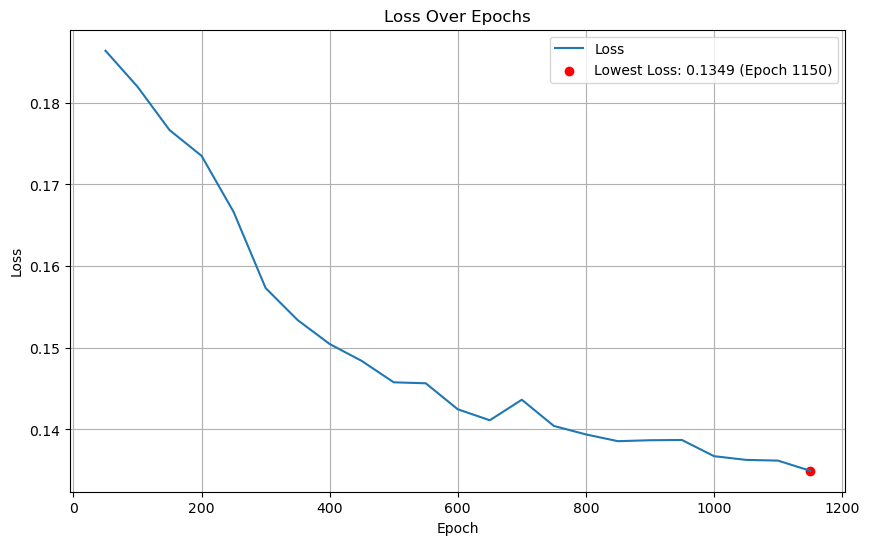

In [65]:
plot_losses_from_checkpoints(checkpoint_dir)

## 4.3 Reconstructed vs Original

Loading latest checkpoint: ./checkpoints/checkpoint_epoch_1150.pth
Model state loaded from checkpoint epoch 1150.


<Figure size 640x480 with 0 Axes>

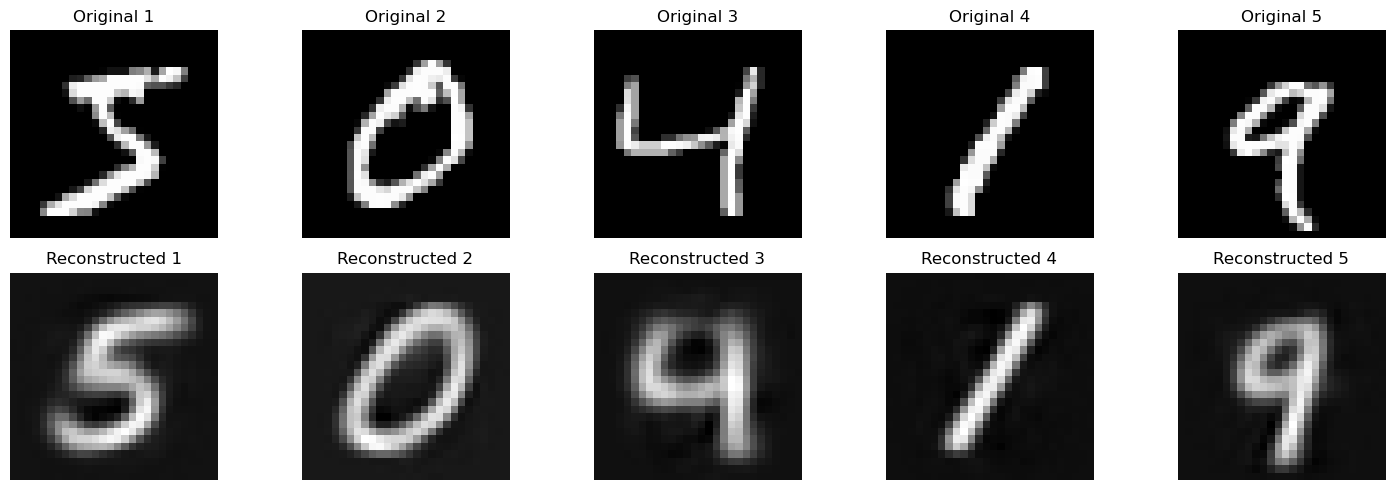

Evaluation plot saved at ./images/eval_1735073649.svg


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

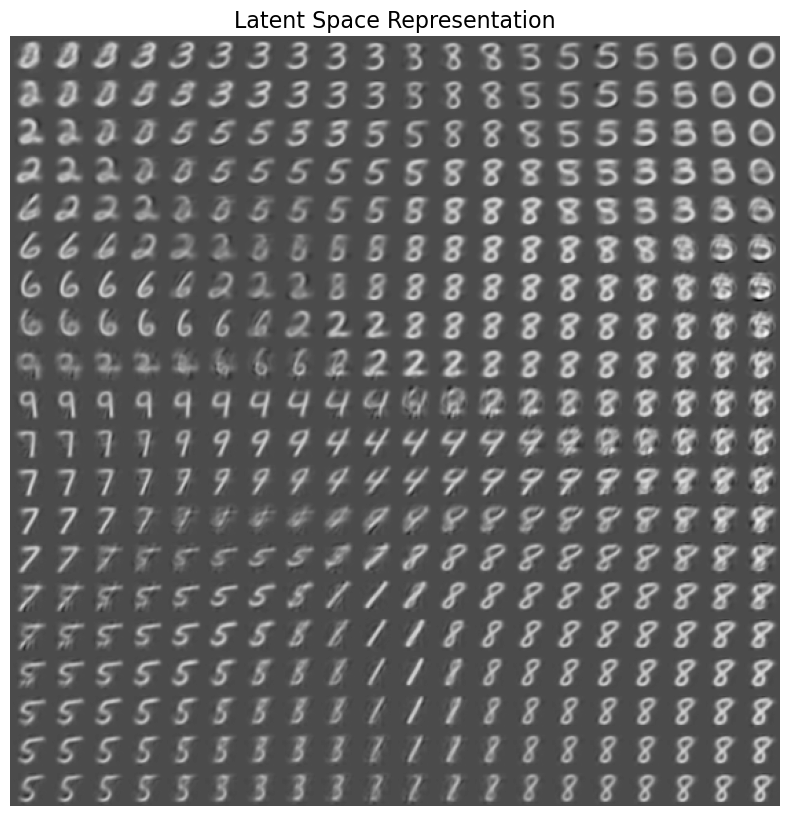

Latent plot saved at ./images/latent_1735073649.svg


In [71]:
evaluate_latest_checkpoint(ae, checkpoint_dir, train_dataset, eval, plot_latent_images,num_latent_dim=20, digit_size=28)

# 5. U-net Diffusion

In [4]:
from typing import List

In [5]:
# Imports
import torch
import torch.nn as nn
import torch.nn.functional as F
from einops import rearrange #pip install einops
from typing import List
import random
import math
from torchvision import datasets, transforms
from torch.utils.data import DataLoader 
from timm.utils import ModelEmaV3 #pip install timm 
from tqdm import tqdm #pip install tqdm
import matplotlib.pyplot as plt #pip install matplotlib
import torch.optim as optim
import numpy as np

class SinusoidalEmbeddings(nn.Module):
    def __init__(self, time_steps:int, embed_dim: int):
        super().__init__()
        position = torch.arange(time_steps).unsqueeze(1).float()
        div = torch.exp(torch.arange(0, embed_dim, 2).float() * -(math.log(10000.0) / embed_dim))
        embeddings = torch.zeros(time_steps, embed_dim, requires_grad=False)
        embeddings[:, 0::2] = torch.sin(position * div)
        embeddings[:, 1::2] = torch.cos(position * div)
        self.embeddings = embeddings

    def forward(self, x, t):
        embeds = self.embeddings[t].to(x.device)
        return embeds[:, :, None, None]

In [6]:
class ResBlock(nn.Module):
    def __init__(self, C: int, num_groups: int, dropout_prob: float):
        super().__init__()
        self.relu = nn.ReLU(inplace=True)
        self.gnorm1 = nn.GroupNorm(num_groups=num_groups, num_channels=C)
        self.gnorm2 = nn.GroupNorm(num_groups=num_groups, num_channels=C)
        self.conv1 = nn.Conv2d(C, C, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(C, C, kernel_size=3, padding=1)
        self.dropout = nn.Dropout(p=dropout_prob, inplace=True)

    def forward(self, x, embeddings):
        x = x + embeddings[:, :x.shape[1], :, :]
        r = self.conv1(self.relu(self.gnorm1(x)))
        r = self.dropout(r)
        r = self.conv2(self.relu(self.gnorm2(r)))
        return r + x

In [7]:
class Attention(nn.Module):
    def __init__(self, C: int, num_heads:int , dropout_prob: float):
        super().__init__()
        self.proj1 = nn.Linear(C, C*3)
        self.proj2 = nn.Linear(C, C)
        self.num_heads = num_heads
        self.dropout_prob = dropout_prob

    def forward(self, x):
        h, w = x.shape[2:]
        x = rearrange(x, 'b c h w -> b (h w) c')
        x = self.proj1(x)
        x = rearrange(x, 'b L (C H K) -> K b H L C', K=3, H=self.num_heads)
        q,k,v = x[0], x[1], x[2]
        x = F.scaled_dot_product_attention(q,k,v, is_causal=False, dropout_p=self.dropout_prob)
        x = rearrange(x, 'b H (h w) C -> b h w (C H)', h=h, w=w)
        x = self.proj2(x)
        return rearrange(x, 'b h w C -> b C h w')

In [8]:
class UnetLayer(nn.Module):
    def __init__(self, 
            upscale: bool, 
            attention: bool, 
            num_groups: int, 
            dropout_prob: float,
            num_heads: int,
            C: int):
        super().__init__()
        self.ResBlock1 = ResBlock(C=C, num_groups=num_groups, dropout_prob=dropout_prob)
        self.ResBlock2 = ResBlock(C=C, num_groups=num_groups, dropout_prob=dropout_prob)
        if upscale:
            self.conv = nn.ConvTranspose2d(C, C//2, kernel_size=4, stride=2, padding=1)
        else:
            self.conv = nn.Conv2d(C, C*2, kernel_size=3, stride=2, padding=1)
        if attention:
            self.attention_layer = Attention(C, num_heads=num_heads, dropout_prob=dropout_prob)

    def forward(self, x, embeddings):
        x = self.ResBlock1(x, embeddings)
        if hasattr(self, 'attention_layer'):
            x = self.attention_layer(x)
        x = self.ResBlock2(x, embeddings)
        return self.conv(x), x

In [9]:
class UNET(nn.Module):
    def __init__(self,
            Channels: List = [64, 128, 256, 512, 512, 384],
            Attentions: List = [False, True, False, False, False, True],
            Upscales: List = [False, False, False, True, True, True],
            num_groups: int = 32,
            dropout_prob: float = 0.1,
            num_heads: int = 8,
            input_channels: int = 1,
            output_channels: int = 1,
            time_steps: int = 1000):
        super().__init__()
        self.num_layers = len(Channels)
        self.shallow_conv = nn.Conv2d(input_channels, Channels[0], kernel_size=3, padding=1)
        out_channels = (Channels[-1]//2)+Channels[0]
        self.late_conv = nn.Conv2d(out_channels, out_channels//2, kernel_size=3, padding=1)
        self.output_conv = nn.Conv2d(out_channels//2, output_channels, kernel_size=1)
        self.relu = nn.ReLU(inplace=True)
        self.embeddings = SinusoidalEmbeddings(time_steps=time_steps, embed_dim=max(Channels))
        for i in range(self.num_layers):
            layer = UnetLayer(
                upscale=Upscales[i],
                attention=Attentions[i],
                num_groups=num_groups,
                dropout_prob=dropout_prob,
                C=Channels[i],
                num_heads=num_heads
            )
            setattr(self, f'Layer{i+1}', layer)

    def forward(self, x, t):
        x = self.shallow_conv(x)
        residuals = []
        for i in range(self.num_layers//2):
            layer = getattr(self, f'Layer{i+1}')
            embeddings = self.embeddings(x, t)
            x, r = layer(x, embeddings)
            residuals.append(r)
        for i in range(self.num_layers//2, self.num_layers):
            layer = getattr(self, f'Layer{i+1}')
            x = torch.concat((layer(x, embeddings)[0], residuals[self.num_layers-i-1]), dim=1)
        return self.output_conv(self.relu(self.late_conv(x)))

In [10]:
class DDPM_Scheduler(nn.Module):
    def __init__(self, num_time_steps: int=1000):
        super().__init__()
        self.beta = torch.linspace(1e-4, 0.02, num_time_steps, requires_grad=False)
        alpha = 1 - self.beta
        self.alpha = torch.cumprod(alpha, dim=0).requires_grad_(False)

    def forward(self, t):
        return self.beta[t], self.alpha[t]

In [11]:
def set_seed(seed: int = 42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)

In [15]:
class MNISTDataset(Dataset):
    def __init__(self, image_path, label_path, transform=None):
        """
        Custom Dataset to load MNIST raw data.

        Args:
            image_path (str): Path to the images file.
            label_path (str): Path to the labels file.
            transform (callable, optional): Transform to apply to images.
        """
        self.images = self._read_images(image_path)
        self.labels = self._read_labels(label_path)
        self.transform = transform
        
    def _read_images(self, filepath):
        with open(filepath, 'rb') as f:
            magic, num, rows, cols = struct.unpack('>IIII', f.read(16))
            images = np.fromfile(f, dtype=np.uint8).reshape(num, rows, cols)
        return images

    def _read_labels(self, filepath):
        with open(filepath, 'rb') as f:
            magic, num = struct.unpack('>II', f.read(8))
            labels = np.fromfile(f, dtype=np.uint8)
        return labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

# Paths to the raw MNIST files
dataset_path = "/home/gridsan/groups/datasets/MNIST/raw"
train_images_path = os.path.join(dataset_path, "train-images-idx3-ubyte")
train_labels_path = os.path.join(dataset_path, "train-labels-idx1-ubyte")
test_images_path = os.path.join(dataset_path, "t10k-images-idx3-ubyte")
test_labels_path = os.path.join(dataset_path, "t10k-labels-idx1-ubyte")

from torchvision import transforms

transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Normalize((0.5,), (0.5,)),    
    transforms.Resize((32, 32)),
])

train_dataset = MNISTDataset(train_images_path, train_labels_path, transform=transform)
test_dataset = MNISTDataset(test_images_path, test_labels_path, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=256, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=256, shuffle=False)

for images, labels in train_loader:
    print(f"Batch images shape: {images.shape}")
    print(f"Batch labels shape: {labels.shape}")
    break


Batch images shape: torch.Size([256, 1, 32, 32])
Batch labels shape: torch.Size([256])


In [17]:
def train(batch_size: int=256,
          num_time_steps: int=1000,
          num_epochs: int=15,
          seed: int=-1,
          ema_decay: float=0.9999,  
          lr=2e-5,
          checkpoint_path: str=None):
    set_seed(random.randint(0, 2**32-1)) if seed == -1 else set_seed(seed)

    #train_dataset = datasets.MNIST(root='./data', train=True, download=False,transform=transforms.ToTensor())
    #train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True, num_workers=4)
    train_dataset = MNISTDataset(train_images_path, train_labels_path, transform=transform)
    test_dataset = MNISTDataset(test_images_path, test_labels_path, transform=transform)
    
    scheduler = DDPM_Scheduler(num_time_steps=num_time_steps)
    model = UNET().cuda()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    ema = ModelEmaV3(model, decay=ema_decay)
    if checkpoint_path is not None:
        checkpoint = torch.load(checkpoint_path)
        model.load_state_dict(checkpoint['weights'])
        ema.load_state_dict(checkpoint['ema'])
        optimizer.load_state_dict(checkpoint['optimizer'])
    criterion = nn.MSELoss(reduction='mean')

    for i in range(num_epochs):
        total_loss = 0
        for bidx, (x,_) in enumerate(tqdm(train_loader, desc=f"Epoch {i+1}/{num_epochs}")):
            x = x.cuda()
            x = F.pad(x, (2,2,2,2))
            t = torch.randint(0,num_time_steps,(batch_size,))
            e = torch.randn_like(x, requires_grad=False)
            a = scheduler.alpha[t].view(batch_size,1,1,1).cuda()
            x = (torch.sqrt(a)*x) + (torch.sqrt(1-a)*e)
            output = model(x, t)
            optimizer.zero_grad()
            loss = criterion(output, e)
            total_loss += loss.item()
            loss.backward()
            optimizer.step()
            ema.update(model)
        print(f'Epoch {i+1} | Loss {total_loss / (60000/batch_size):.5f}')

    checkpoint = {
        'weights': model.state_dict(),
        'optimizer': optimizer.state_dict(),
        'ema': ema.state_dict()
    }
    torch.save(checkpoint, 'checkpoint_diffusion/MNIST')

In [18]:
def display_reverse(images: List):
    fig, axes = plt.subplots(1, 10, figsize=(10,1))
    for i, ax in enumerate(axes.flat):
        x = images[i].squeeze(0)
        x = rearrange(x, 'c h w -> h w c')
        x = x.numpy()
        ax.imshow(x)
        ax.axis('off')
    plt.show()

def inference(checkpoint_path: str=None,
              num_time_steps: int=1000,
              ema_decay: float=0.9999, ):
    checkpoint = torch.load(checkpoint_path)
    model = UNET().cuda()
    model.load_state_dict(checkpoint['weights'])
    ema = ModelEmaV3(model, decay=ema_decay)
    ema.load_state_dict(checkpoint['ema'])
    scheduler = DDPM_Scheduler(num_time_steps=num_time_steps)
    times = [0,15,50,100,200,300,400,550,700,999]
    images = []

    with torch.no_grad():
        model = ema.module.eval()
        for i in range(10):
            z = torch.randn(1, 1, 32, 32)
            for t in reversed(range(1, num_time_steps)):
                t = [t]
                temp = (scheduler.beta[t]/( (torch.sqrt(1-scheduler.alpha[t]))*(torch.sqrt(1-scheduler.beta[t])) ))
                z = (1/(torch.sqrt(1-scheduler.beta[t])))*z - (temp*model(z.cuda(),t).cpu())
                if t[0] in times:
                    images.append(z)
                e = torch.randn(1, 1, 32, 32)
                z = z + (e*torch.sqrt(scheduler.beta[t]))
            temp = scheduler.beta[0]/( (torch.sqrt(1-scheduler.alpha[0]))*(torch.sqrt(1-scheduler.beta[0])) )
            x = (1/(torch.sqrt(1-scheduler.beta[0])))*z - (temp*model(z.cuda(),[0]).cpu())

            images.append(x)
            x = rearrange(x.squeeze(0), 'c h w -> h w c').detach()
            x = x.numpy()
            plt.imshow(x)
            plt.show()
            display_reverse(images)
            images = []

In [20]:
def main():
    train(checkpoint_path='/home/gridsan/yyao/Research_Projects/Microstructure_Enough/deep_faker/demo/checkpoint_diffusion/MNIST', 
          lr=2e-5,
          num_epochs=2
         )
    inference('/home/gridsan/yyao/Research_Projects/Microstructure_Enough/deep_faker/demo/checkpoint_diffusion/MNIST')

if __name__ == '__main__':
    main()

IsADirectoryError: [Errno 21] Is a directory: '/home/gridsan/yyao/Research_Projects/Microstructure_Enough/deep_faker/demo/checkpoint_diffusion/MNIST'